In [1]:
from scipy.io import arff
from scipy.spatial.distance import euclidean
import pandas as pd
import joblib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder , StandardScaler , PolynomialFeatures , MinMaxScaler
from sklearn.model_selection  import train_test_split , cross_val_score , KFold
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import tensorflow as tf
from keras.regularizers import l1_l2
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import LeakyReLU, Activation, Input, Dense, Dropout, Concatenate, BatchNormalization


In [2]:
# load trained RF BB model
BB_clf = joblib.load("/home/odedrot/DL_ex_4/trained_rf_80_scaled.joblib")
# probabilities = BB_clf.predict(X_test)

In [3]:
# np.random.seed(42)
# tf.random.set_seed(42)
feature_dim = 8
conf_dim = 1

noise_dim = 5
batch_size  = 32
num_epochs  = 5000
optimizer = Adam(lr=0.0005)# , beta_1=0.5)

In [4]:
def build_generator(noise_dim):
    model = Sequential()
    model.add(Dense(units=32,input_dim=noise_dim+conf_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(units=64))
    model.add(LeakyReLU(0.2))
#     model.add(Dense(units=128))
#     model.add(LeakyReLU(0.2))
    model.add(Dense(units=feature_dim, activation='tanh'))
#     model.add(LeakyReLU(0.2))
    z = Input(shape=(noise_dim, ))
    label = Input(shape=(1,))
    joined_representation = Concatenate(axis=1)([z, label])
    output = model(joined_representation)
    return Model([z, label], output)

def build_discriminator(feature_dim):
    model = Sequential()
    model.add(Dense(units=64,input_dim=feature_dim+conf_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(units=32))
    model.add(LeakyReLU(0.2))
#     model.add(Dense(units=32))
#     model.add(LeakyReLU(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    features = Input(shape=feature_dim)
    label = Input(shape=(1,))
    concatenated = Concatenate(axis=1)([features, label])
    prediction = model(concatenated)
    return Model([features, label], prediction)

disc = build_discriminator(feature_dim)
disc.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())
gen = build_generator(noise_dim)
z = Input(shape=(noise_dim,))
label = Input(shape=(1,))
features = gen([z, label])
disc.trainable = False
prediction = disc([features, label])
cgan = Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [5]:
real = np.ones(batch_size)    
fake = np.zeros(batch_size)    
g_loss_ = []
d_loss_ = []
d_loss_fake_=[]
d_loss_real_=[]
d_acc_fake_=[]
d_acc_real_=[]
for epoch in range(num_epochs):
    disc.trainable = True
    noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    
    c_batch      = np.random.uniform(0, 1, (batch_size, conf_dim))
    generated_features = gen.predict([noise_batch,c_batch]) # (32, 8)
#     y_label = BB_clf.predict(generated_features) # 0,1
    y_label = BB_clf.predict_proba(generated_features)[:,0] # [prob for 0, prob for 1]
    d_loss_real = disc.train_on_batch([generated_features, y_label],real) # scalar (avg of batch)
    # disc gets c lael
    noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    
    c_batch      = np.random.uniform(0, 1, (batch_size, conf_dim))  
    generated_features = gen.predict([noise_batch, c_batch])
    d_loss_fake = disc.train_on_batch([generated_features,c_batch],fake) # scalar (avg of batch)
    
    d_loss = 0.5*(d_loss_real[0] + d_loss_fake[0]) # [0]-loss , [1]-acc
    
    # train gen (freeze disc)
    for i in range(2):
        disc.trainable = False
        noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    
        c_batch      = np.random.uniform(0, 1, (batch_size, conf_dim))  
        g_loss = cgan.train_on_batch([noise_batch, c_batch], real)
    
    print('epoch: ' + str(epoch) , ' D_loss_real ' + str(d_loss_real[0]) , ' D_loss_fake ' + str(d_loss_fake[0]) , ' G_loss ' + str(g_loss) )

    g_loss_.append(g_loss)
    d_loss_.append(d_loss)
    d_loss_fake_.append(d_loss_fake[0])
    d_loss_real_.append(d_loss_real[0])
    d_acc_fake_.append(d_loss_fake[1])
    d_acc_real_.append(d_loss_real[1])
    
    if epochs > 2000 and d_loss_real[1]<0.6:
        break



epoch: 0  D_loss_real 0.5928259491920471  D_loss_fake 0.8046194314956665  G_loss 0.6069357395172119
epoch: 1  D_loss_real 0.5688719153404236  D_loss_fake 0.80729079246521  G_loss 0.5948070287704468
epoch: 2  D_loss_real 0.5576934814453125  D_loss_fake 0.8389588594436646  G_loss 0.5733901262283325
epoch: 3  D_loss_real 0.5367674231529236  D_loss_fake 0.8428053855895996  G_loss 0.5645011067390442
epoch: 4  D_loss_real 0.5407103300094604  D_loss_fake 0.85663902759552  G_loss 0.5450419187545776
epoch: 5  D_loss_real 0.5266560316085815  D_loss_fake 0.8864667415618896  G_loss 0.5521687269210815
epoch: 6  D_loss_real 0.5233132839202881  D_loss_fake 0.8724120855331421  G_loss 0.5361361503601074
epoch: 7  D_loss_real 0.5117086172103882  D_loss_fake 0.9035671949386597  G_loss 0.5378137826919556
epoch: 8  D_loss_real 0.5127530097961426  D_loss_fake 0.8769310712814331  G_loss 0.5335334539413452
epoch: 9  D_loss_real 0.5137735605239868  D_loss_fake 0.8976672291755676  G_loss 0.547885000705719
epoch

epoch: 82  D_loss_real 0.6760416030883789  D_loss_fake 0.691119909286499  G_loss 0.7016420364379883
epoch: 83  D_loss_real 0.6756587028503418  D_loss_fake 0.6830368041992188  G_loss 0.6942506432533264
epoch: 84  D_loss_real 0.6777156591415405  D_loss_fake 0.6897501945495605  G_loss 0.6955338716506958
epoch: 85  D_loss_real 0.6767288446426392  D_loss_fake 0.6708623170852661  G_loss 0.7105245590209961
epoch: 86  D_loss_real 0.67725670337677  D_loss_fake 0.6802666187286377  G_loss 0.701002836227417
epoch: 87  D_loss_real 0.6774968504905701  D_loss_fake 0.6814289093017578  G_loss 0.7098572254180908
epoch: 88  D_loss_real 0.6784613132476807  D_loss_fake 0.6886870861053467  G_loss 0.7081850171089172
epoch: 89  D_loss_real 0.6767176985740662  D_loss_fake 0.6657319068908691  G_loss 0.7122828960418701
epoch: 90  D_loss_real 0.6782577037811279  D_loss_fake 0.6926195621490479  G_loss 0.7014760375022888
epoch: 91  D_loss_real 0.6786984205245972  D_loss_fake 0.6836369633674622  G_loss 0.70329481363

epoch: 243  D_loss_real 0.5232802629470825  D_loss_fake 0.6309407949447632  G_loss 1.0070050954818726
epoch: 244  D_loss_real 0.5216357707977295  D_loss_fake 0.5796517729759216  G_loss 1.1006799936294556
epoch: 245  D_loss_real 0.5203103423118591  D_loss_fake 0.5525362491607666  G_loss 1.0555405616760254
epoch: 246  D_loss_real 0.5193294286727905  D_loss_fake 0.6531394124031067  G_loss 1.1384639739990234
epoch: 247  D_loss_real 0.521123468875885  D_loss_fake 0.6386805176734924  G_loss 1.1994333267211914
epoch: 248  D_loss_real 0.5213854908943176  D_loss_fake 0.6218306422233582  G_loss 1.0683562755584717
epoch: 249  D_loss_real 0.523780107498169  D_loss_fake 0.4484822750091553  G_loss 1.0813322067260742
epoch: 250  D_loss_real 0.5211901664733887  D_loss_fake 0.5811487436294556  G_loss 0.9898150563240051
epoch: 251  D_loss_real 0.5211685299873352  D_loss_fake 0.4522518217563629  G_loss 0.9804584980010986
epoch: 252  D_loss_real 0.5219519734382629  D_loss_fake 0.4323956370353699  G_loss 1

epoch: 324  D_loss_real 0.45794475078582764  D_loss_fake 0.5498958826065063  G_loss 1.0162804126739502
epoch: 325  D_loss_real 0.45766618847846985  D_loss_fake 0.6282925009727478  G_loss 1.0614770650863647
epoch: 326  D_loss_real 0.45984092354774475  D_loss_fake 0.594967246055603  G_loss 1.5748370885849
epoch: 327  D_loss_real 0.4626035690307617  D_loss_fake 0.5109474658966064  G_loss 1.2841771841049194
epoch: 328  D_loss_real 0.4594131112098694  D_loss_fake 0.47877511382102966  G_loss 1.0996108055114746
epoch: 329  D_loss_real 0.45677119493484497  D_loss_fake 0.5446124076843262  G_loss 1.4440176486968994
epoch: 330  D_loss_real 0.45641955733299255  D_loss_fake 0.5263540744781494  G_loss 1.0114645957946777
epoch: 331  D_loss_real 0.45753151178359985  D_loss_fake 0.4941822588443756  G_loss 1.5837695598602295
epoch: 332  D_loss_real 0.45647695660591125  D_loss_fake 0.46078288555145264  G_loss 1.3262282609939575
epoch: 333  D_loss_real 0.4568072259426117  D_loss_fake 0.4892417788505554  G

epoch: 405  D_loss_real 0.5465116500854492  D_loss_fake 0.6923545002937317  G_loss 0.9492583274841309
epoch: 406  D_loss_real 0.5470887422561646  D_loss_fake 0.5854637622833252  G_loss 0.9066035747528076
epoch: 407  D_loss_real 0.5492818355560303  D_loss_fake 0.6518844366073608  G_loss 1.1113911867141724
epoch: 408  D_loss_real 0.5467498898506165  D_loss_fake 0.6422009468078613  G_loss 1.0290393829345703
epoch: 409  D_loss_real 0.5421488881111145  D_loss_fake 0.5994998216629028  G_loss 0.895615816116333
epoch: 410  D_loss_real 0.5367072224617004  D_loss_fake 0.6333176493644714  G_loss 1.0585603713989258
epoch: 411  D_loss_real 0.531566858291626  D_loss_fake 0.6433677673339844  G_loss 0.8991016149520874
epoch: 412  D_loss_real 0.5270833969116211  D_loss_fake 0.567042350769043  G_loss 1.0250667333602905
epoch: 413  D_loss_real 0.5251978635787964  D_loss_fake 0.530769944190979  G_loss 1.2699276208877563
epoch: 414  D_loss_real 0.5233471393585205  D_loss_fake 0.561368465423584  G_loss 0.90

epoch: 486  D_loss_real 0.6772183775901794  D_loss_fake 0.6884408593177795  G_loss 0.87137371301651
epoch: 487  D_loss_real 0.6406505107879639  D_loss_fake 0.6812607645988464  G_loss 0.861426830291748
epoch: 488  D_loss_real 0.6326254606246948  D_loss_fake 0.6832566261291504  G_loss 0.8749635815620422
epoch: 489  D_loss_real 0.6566889882087708  D_loss_fake 0.6068379878997803  G_loss 0.7364450693130493
epoch: 490  D_loss_real 0.6681897640228271  D_loss_fake 0.6385839581489563  G_loss 0.8739607930183411
epoch: 491  D_loss_real 0.7387049198150635  D_loss_fake 0.653304398059845  G_loss 0.7796477675437927
epoch: 492  D_loss_real 0.7113922238349915  D_loss_fake 0.6151591539382935  G_loss 0.8965290784835815
epoch: 493  D_loss_real 0.6258018016815186  D_loss_fake 0.5676568746566772  G_loss 0.8739937543869019
epoch: 494  D_loss_real 0.6458309888839722  D_loss_fake 0.6102006435394287  G_loss 0.8683255910873413
epoch: 495  D_loss_real 0.7654167413711548  D_loss_fake 0.6893184781074524  G_loss 0.8

epoch: 567  D_loss_real 0.7550151348114014  D_loss_fake 0.7880441546440125  G_loss 0.6366398334503174
epoch: 568  D_loss_real 0.6628372073173523  D_loss_fake 0.7678422331809998  G_loss 0.6058283448219299
epoch: 569  D_loss_real 0.6254998445510864  D_loss_fake 0.8345439434051514  G_loss 0.6192218065261841
epoch: 570  D_loss_real 0.7087187767028809  D_loss_fake 0.7853749990463257  G_loss 0.6316832304000854
epoch: 571  D_loss_real 0.6802172660827637  D_loss_fake 0.7958073616027832  G_loss 0.6221976280212402
epoch: 572  D_loss_real 0.6858667135238647  D_loss_fake 0.8016343116760254  G_loss 0.6140249967575073
epoch: 573  D_loss_real 0.6439336538314819  D_loss_fake 0.7909328937530518  G_loss 0.6123189926147461
epoch: 574  D_loss_real 0.6157092452049255  D_loss_fake 0.7725502252578735  G_loss 0.6049405336380005
epoch: 575  D_loss_real 0.6301153302192688  D_loss_fake 0.7983450889587402  G_loss 0.6161192655563354
epoch: 576  D_loss_real 0.63450026512146  D_loss_fake 0.7803514003753662  G_loss 0

epoch: 648  D_loss_real 0.6149631142616272  D_loss_fake 0.6034541130065918  G_loss 0.9043540954589844
epoch: 649  D_loss_real 0.6307557225227356  D_loss_fake 0.6420444250106812  G_loss 0.7643374800682068
epoch: 650  D_loss_real 0.6204065084457397  D_loss_fake 0.6602671146392822  G_loss 0.803760290145874
epoch: 651  D_loss_real 0.6291643381118774  D_loss_fake 0.636284351348877  G_loss 0.8015363216400146
epoch: 652  D_loss_real 0.6149297952651978  D_loss_fake 0.653362512588501  G_loss 0.7323567867279053
epoch: 653  D_loss_real 0.6174821257591248  D_loss_fake 0.6706368923187256  G_loss 0.7798011302947998
epoch: 654  D_loss_real 0.6134271621704102  D_loss_fake 0.5780657529830933  G_loss 0.7704125642776489
epoch: 655  D_loss_real 0.6052471399307251  D_loss_fake 0.6581531763076782  G_loss 0.7583359479904175
epoch: 656  D_loss_real 0.5947842597961426  D_loss_fake 0.61518394947052  G_loss 0.764367401599884
epoch: 657  D_loss_real 0.6024607419967651  D_loss_fake 0.6116918325424194  G_loss 0.759

epoch: 729  D_loss_real 0.5914860367774963  D_loss_fake 0.5758237242698669  G_loss 0.8520309925079346
epoch: 730  D_loss_real 0.6115067005157471  D_loss_fake 0.5711736679077148  G_loss 1.015166997909546
epoch: 731  D_loss_real 0.616277813911438  D_loss_fake 0.5695828795433044  G_loss 0.9060519337654114
epoch: 732  D_loss_real 0.5952582955360413  D_loss_fake 0.5687143802642822  G_loss 1.117950677871704
epoch: 733  D_loss_real 0.6072845458984375  D_loss_fake 0.5281102657318115  G_loss 0.8941491842269897
epoch: 734  D_loss_real 0.6008806228637695  D_loss_fake 0.5399922728538513  G_loss 0.7125675678253174
epoch: 735  D_loss_real 0.6015965938568115  D_loss_fake 0.6165212392807007  G_loss 0.9264791011810303
epoch: 736  D_loss_real 0.5908543467521667  D_loss_fake 0.6161477565765381  G_loss 0.8741827607154846
epoch: 737  D_loss_real 0.5821952223777771  D_loss_fake 0.5829778909683228  G_loss 0.9953246116638184
epoch: 738  D_loss_real 0.5658352375030518  D_loss_fake 0.6309451460838318  G_loss 0.

epoch: 810  D_loss_real 0.5409945249557495  D_loss_fake 0.46706196665763855  G_loss 0.9280254244804382
epoch: 811  D_loss_real 0.5279098749160767  D_loss_fake 0.5556893944740295  G_loss 1.0539216995239258
epoch: 812  D_loss_real 0.5567096471786499  D_loss_fake 0.5990279912948608  G_loss 1.142893671989441
epoch: 813  D_loss_real 0.5555304884910583  D_loss_fake 0.5068938732147217  G_loss 0.8992300033569336
epoch: 814  D_loss_real 0.5593395829200745  D_loss_fake 0.5581069588661194  G_loss 1.0310465097427368
epoch: 815  D_loss_real 0.552020788192749  D_loss_fake 0.6047021150588989  G_loss 1.1457393169403076
epoch: 816  D_loss_real 0.5484298467636108  D_loss_fake 0.5850402116775513  G_loss 0.9713239669799805
epoch: 817  D_loss_real 0.5541263818740845  D_loss_fake 0.5828377604484558  G_loss 1.0038102865219116
epoch: 818  D_loss_real 0.5603930950164795  D_loss_fake 0.5391699075698853  G_loss 0.8753741979598999
epoch: 819  D_loss_real 0.5548781156539917  D_loss_fake 0.6189836263656616  G_loss 

epoch: 891  D_loss_real 0.555851936340332  D_loss_fake 0.6364039182662964  G_loss 0.9116227626800537
epoch: 892  D_loss_real 0.5395912528038025  D_loss_fake 0.5737409591674805  G_loss 1.0303518772125244
epoch: 893  D_loss_real 0.5625231862068176  D_loss_fake 0.5563004612922668  G_loss 1.045807123184204
epoch: 894  D_loss_real 0.5694026350975037  D_loss_fake 0.579984188079834  G_loss 1.0943782329559326
epoch: 895  D_loss_real 0.5512809157371521  D_loss_fake 0.4910699129104614  G_loss 1.1453678607940674
epoch: 896  D_loss_real 0.5633020997047424  D_loss_fake 0.6505429744720459  G_loss 0.8847376704216003
epoch: 897  D_loss_real 0.5903589725494385  D_loss_fake 0.5669185519218445  G_loss 1.2214727401733398
epoch: 898  D_loss_real 0.5735335350036621  D_loss_fake 0.6437435150146484  G_loss 1.1497892141342163
epoch: 899  D_loss_real 0.5480226278305054  D_loss_fake 0.5966428518295288  G_loss 1.1702674627304077
epoch: 900  D_loss_real 0.5672128200531006  D_loss_fake 0.6274479627609253  G_loss 1.

epoch: 973  D_loss_real 0.5723329186439514  D_loss_fake 0.4033222198486328  G_loss 1.0505216121673584
epoch: 974  D_loss_real 0.5159673690795898  D_loss_fake 0.49715691804885864  G_loss 1.031881332397461
epoch: 975  D_loss_real 0.5371846556663513  D_loss_fake 0.6382795572280884  G_loss 0.9608557820320129
epoch: 976  D_loss_real 0.5406526327133179  D_loss_fake 0.5545430183410645  G_loss 0.9998352527618408
epoch: 977  D_loss_real 0.5944830775260925  D_loss_fake 0.5870633125305176  G_loss 0.9301743507385254
epoch: 978  D_loss_real 0.5436572432518005  D_loss_fake 0.5874233841896057  G_loss 1.0537930727005005
epoch: 979  D_loss_real 0.5077501535415649  D_loss_fake 0.6243683099746704  G_loss 1.0685749053955078
epoch: 980  D_loss_real 0.5261919498443604  D_loss_fake 0.5647422075271606  G_loss 1.0413134098052979
epoch: 981  D_loss_real 0.5582292079925537  D_loss_fake 0.5115953683853149  G_loss 1.0552855730056763
epoch: 982  D_loss_real 0.5599413514137268  D_loss_fake 0.5951634049415588  G_loss

epoch: 1054  D_loss_real 0.5863571166992188  D_loss_fake 0.577302098274231  G_loss 1.0308972597122192
epoch: 1055  D_loss_real 0.5788240432739258  D_loss_fake 0.5915193557739258  G_loss 0.9840363264083862
epoch: 1056  D_loss_real 0.5841801166534424  D_loss_fake 0.5796711444854736  G_loss 0.9012466669082642
epoch: 1057  D_loss_real 0.5740085244178772  D_loss_fake 0.5306164026260376  G_loss 0.9424315094947815
epoch: 1058  D_loss_real 0.5333502292633057  D_loss_fake 0.5875767469406128  G_loss 0.8348496556282043
epoch: 1059  D_loss_real 0.5692588090896606  D_loss_fake 0.6554911136627197  G_loss 1.1146419048309326
epoch: 1060  D_loss_real 0.5762551426887512  D_loss_fake 0.5932201743125916  G_loss 0.8076080679893494
epoch: 1061  D_loss_real 0.5448279976844788  D_loss_fake 0.5618416666984558  G_loss 0.9496110677719116
epoch: 1062  D_loss_real 0.5437660217285156  D_loss_fake 0.5955805778503418  G_loss 0.9654384851455688
epoch: 1063  D_loss_real 0.5341429710388184  D_loss_fake 0.645220935344696

epoch: 1134  D_loss_real 0.5456515550613403  D_loss_fake 0.5462518334388733  G_loss 1.0802721977233887
epoch: 1135  D_loss_real 0.5008115172386169  D_loss_fake 0.4893778860569  G_loss 1.1267492771148682
epoch: 1136  D_loss_real 0.5287090539932251  D_loss_fake 0.5598695874214172  G_loss 1.0677518844604492
epoch: 1137  D_loss_real 0.5549505352973938  D_loss_fake 0.5835597515106201  G_loss 1.0497595071792603
epoch: 1138  D_loss_real 0.526953935623169  D_loss_fake 0.6114585995674133  G_loss 1.09798264503479
epoch: 1139  D_loss_real 0.5011621713638306  D_loss_fake 0.6037342548370361  G_loss 1.032257318496704
epoch: 1140  D_loss_real 0.4986597001552582  D_loss_fake 0.6310908794403076  G_loss 1.0412284135818481
epoch: 1141  D_loss_real 0.5347915887832642  D_loss_fake 0.5788935422897339  G_loss 1.0141935348510742
epoch: 1142  D_loss_real 0.5214769840240479  D_loss_fake 0.6473344564437866  G_loss 0.9413629770278931
epoch: 1143  D_loss_real 0.5204339027404785  D_loss_fake 0.5601979494094849  G_l

epoch: 1214  D_loss_real 0.5609350204467773  D_loss_fake 0.6592221260070801  G_loss 1.1258397102355957
epoch: 1215  D_loss_real 0.6769112348556519  D_loss_fake 0.5498926043510437  G_loss 0.9201173186302185
epoch: 1216  D_loss_real 0.611430823802948  D_loss_fake 0.6207472681999207  G_loss 0.9396135807037354
epoch: 1217  D_loss_real 0.5793870091438293  D_loss_fake 0.6372262835502625  G_loss 1.145614504814148
epoch: 1218  D_loss_real 0.629927396774292  D_loss_fake 0.5191855430603027  G_loss 0.9096060395240784
epoch: 1219  D_loss_real 0.5795449018478394  D_loss_fake 0.6218264102935791  G_loss 1.2903082370758057
epoch: 1220  D_loss_real 0.6258341670036316  D_loss_fake 0.6491585373878479  G_loss 1.084648609161377
epoch: 1221  D_loss_real 0.5551313757896423  D_loss_fake 0.6087566614151001  G_loss 1.1358647346496582
epoch: 1222  D_loss_real 0.6115052700042725  D_loss_fake 0.5074086785316467  G_loss 1.0778812170028687
epoch: 1223  D_loss_real 0.6040421724319458  D_loss_fake 0.5814829468727112  

epoch: 1294  D_loss_real 0.5716995596885681  D_loss_fake 0.5235867500305176  G_loss 0.9379404783248901
epoch: 1295  D_loss_real 0.5152677297592163  D_loss_fake 0.5336523056030273  G_loss 1.1129155158996582
epoch: 1296  D_loss_real 0.532689094543457  D_loss_fake 0.4637466073036194  G_loss 1.1525256633758545
epoch: 1297  D_loss_real 0.6336194276809692  D_loss_fake 0.6530299782752991  G_loss 1.2575265169143677
epoch: 1298  D_loss_real 0.5770930051803589  D_loss_fake 0.4713243246078491  G_loss 1.2023231983184814
epoch: 1299  D_loss_real 0.5988134145736694  D_loss_fake 0.6758591532707214  G_loss 1.1016337871551514
epoch: 1300  D_loss_real 0.631240725517273  D_loss_fake 0.6661742925643921  G_loss 1.1828795671463013
epoch: 1301  D_loss_real 0.48638471961021423  D_loss_fake 0.5482592582702637  G_loss 1.2109942436218262
epoch: 1302  D_loss_real 0.5571943521499634  D_loss_fake 0.716286301612854  G_loss 0.984534740447998
epoch: 1303  D_loss_real 0.5422428846359253  D_loss_fake 0.6014991402626038 

epoch: 1374  D_loss_real 0.5433264970779419  D_loss_fake 0.6270620226860046  G_loss 0.9748534560203552
epoch: 1375  D_loss_real 0.5010091066360474  D_loss_fake 0.5390380620956421  G_loss 1.2139779329299927
epoch: 1376  D_loss_real 0.5509716272354126  D_loss_fake 0.5699102282524109  G_loss 1.253159523010254
epoch: 1377  D_loss_real 0.5175497531890869  D_loss_fake 0.6105398535728455  G_loss 1.7584465742111206
epoch: 1378  D_loss_real 0.5088987946510315  D_loss_fake 0.5526865720748901  G_loss 0.9673935174942017
epoch: 1379  D_loss_real 0.4957684874534607  D_loss_fake 0.5400108695030212  G_loss 1.2724933624267578
epoch: 1380  D_loss_real 0.5458884239196777  D_loss_fake 0.5875206589698792  G_loss 1.1688995361328125
epoch: 1381  D_loss_real 0.4816052317619324  D_loss_fake 0.6161779165267944  G_loss 1.252258539199829
epoch: 1382  D_loss_real 0.5320073366165161  D_loss_fake 0.5379840135574341  G_loss 1.2416324615478516
epoch: 1383  D_loss_real 0.482997864484787  D_loss_fake 0.5712078213691711 

epoch: 1454  D_loss_real 0.5118518471717834  D_loss_fake 0.5257217884063721  G_loss 0.9456027150154114
epoch: 1455  D_loss_real 0.552787184715271  D_loss_fake 0.5708526968955994  G_loss 1.0748841762542725
epoch: 1456  D_loss_real 0.5565884113311768  D_loss_fake 0.5871419310569763  G_loss 0.9815471172332764
epoch: 1457  D_loss_real 0.5485243797302246  D_loss_fake 0.4781903028488159  G_loss 1.0906767845153809
epoch: 1458  D_loss_real 0.5296164155006409  D_loss_fake 0.6318802833557129  G_loss 1.0939172506332397
epoch: 1459  D_loss_real 0.554711103439331  D_loss_fake 0.48000872135162354  G_loss 1.1984539031982422
epoch: 1460  D_loss_real 0.5285307765007019  D_loss_fake 0.5568015575408936  G_loss 1.1372772455215454
epoch: 1461  D_loss_real 0.5269777178764343  D_loss_fake 0.5500671863555908  G_loss 1.4631202220916748
epoch: 1462  D_loss_real 0.555272102355957  D_loss_fake 0.48437196016311646  G_loss 1.0128943920135498
epoch: 1463  D_loss_real 0.5383782386779785  D_loss_fake 0.546436369419097

epoch: 1534  D_loss_real 0.5723453164100647  D_loss_fake 0.6266753077507019  G_loss 1.042968988418579
epoch: 1535  D_loss_real 0.5081387758255005  D_loss_fake 0.5588170289993286  G_loss 0.9939765334129333
epoch: 1536  D_loss_real 0.48150572180747986  D_loss_fake 0.5654394626617432  G_loss 0.8408061861991882
epoch: 1537  D_loss_real 0.4904910922050476  D_loss_fake 0.5949233770370483  G_loss 0.9879485368728638
epoch: 1538  D_loss_real 0.5019556283950806  D_loss_fake 0.6325268745422363  G_loss 1.0735936164855957
epoch: 1539  D_loss_real 0.5028136968612671  D_loss_fake 0.6358006596565247  G_loss 1.269697904586792
epoch: 1540  D_loss_real 0.5588645339012146  D_loss_fake 0.6046411991119385  G_loss 1.1315300464630127
epoch: 1541  D_loss_real 0.533668041229248  D_loss_fake 0.4886583387851715  G_loss 1.3513786792755127
epoch: 1542  D_loss_real 0.5681602954864502  D_loss_fake 0.5579291582107544  G_loss 0.8730978965759277
epoch: 1543  D_loss_real 0.5350915789604187  D_loss_fake 0.4903793632984161

epoch: 1614  D_loss_real 0.4944959282875061  D_loss_fake 0.6251579523086548  G_loss 1.2683066129684448
epoch: 1615  D_loss_real 0.5225947499275208  D_loss_fake 0.5329618453979492  G_loss 1.1622213125228882
epoch: 1616  D_loss_real 0.552205502986908  D_loss_fake 0.5719473361968994  G_loss 1.0171856880187988
epoch: 1617  D_loss_real 0.5577600002288818  D_loss_fake 0.582589328289032  G_loss 1.553207516670227
epoch: 1618  D_loss_real 0.5251548886299133  D_loss_fake 0.6030188202857971  G_loss 1.243822455406189
epoch: 1619  D_loss_real 0.48545119166374207  D_loss_fake 0.5049336552619934  G_loss 1.1638026237487793
epoch: 1620  D_loss_real 0.5316355228424072  D_loss_fake 0.6054893732070923  G_loss 1.1849008798599243
epoch: 1621  D_loss_real 0.4998480975627899  D_loss_fake 0.535336434841156  G_loss 1.1092694997787476
epoch: 1622  D_loss_real 0.56734699010849  D_loss_fake 0.554770827293396  G_loss 1.6576941013336182
epoch: 1623  D_loss_real 0.5554965734481812  D_loss_fake 0.4558255076408386  G_l

epoch: 1695  D_loss_real 0.5282702445983887  D_loss_fake 0.6244299411773682  G_loss 1.1459062099456787
epoch: 1696  D_loss_real 0.47304099798202515  D_loss_fake 0.5623083114624023  G_loss 1.264373779296875
epoch: 1697  D_loss_real 0.5480403900146484  D_loss_fake 0.6119311451911926  G_loss 0.8752945065498352
epoch: 1698  D_loss_real 0.5481842756271362  D_loss_fake 0.5878085494041443  G_loss 1.1550202369689941
epoch: 1699  D_loss_real 0.5268157720565796  D_loss_fake 0.5714353322982788  G_loss 1.4225025177001953
epoch: 1700  D_loss_real 0.5541837215423584  D_loss_fake 0.5706688165664673  G_loss 1.136256217956543
epoch: 1701  D_loss_real 0.5286608934402466  D_loss_fake 0.5681273937225342  G_loss 1.3376893997192383
epoch: 1702  D_loss_real 0.47422367334365845  D_loss_fake 0.5473799705505371  G_loss 1.3708221912384033
epoch: 1703  D_loss_real 0.5041052103042603  D_loss_fake 0.5255228281021118  G_loss 1.0081472396850586
epoch: 1704  D_loss_real 0.5137671232223511  D_loss_fake 0.55825012922286

epoch: 1775  D_loss_real 0.5241103172302246  D_loss_fake 0.5198041200637817  G_loss 1.3086497783660889
epoch: 1776  D_loss_real 0.48259860277175903  D_loss_fake 0.5449819564819336  G_loss 1.332072138786316
epoch: 1777  D_loss_real 0.5183577537536621  D_loss_fake 0.46355319023132324  G_loss 1.196692943572998
epoch: 1778  D_loss_real 0.5212728977203369  D_loss_fake 0.5982893705368042  G_loss 1.2557430267333984
epoch: 1779  D_loss_real 0.5550745725631714  D_loss_fake 0.6101236343383789  G_loss 1.3336212635040283
epoch: 1780  D_loss_real 0.4697093963623047  D_loss_fake 0.5826285481452942  G_loss 1.6680688858032227
epoch: 1781  D_loss_real 0.5327203869819641  D_loss_fake 0.5202672481536865  G_loss 1.3919904232025146
epoch: 1782  D_loss_real 0.5040370225906372  D_loss_fake 0.5562748908996582  G_loss 1.1823748350143433
epoch: 1783  D_loss_real 0.4750567376613617  D_loss_fake 0.49079006910324097  G_loss 1.304405689239502
epoch: 1784  D_loss_real 0.472476065158844  D_loss_fake 0.540291666984558

epoch: 1855  D_loss_real 0.4438677132129669  D_loss_fake 0.5336759090423584  G_loss 1.4908020496368408
epoch: 1856  D_loss_real 0.4633482098579407  D_loss_fake 0.5187548398971558  G_loss 1.4737377166748047
epoch: 1857  D_loss_real 0.48366886377334595  D_loss_fake 0.6452538371086121  G_loss 0.9610702395439148
epoch: 1858  D_loss_real 0.5003882646560669  D_loss_fake 0.607882022857666  G_loss 1.0805492401123047
epoch: 1859  D_loss_real 0.5010184645652771  D_loss_fake 0.6083399057388306  G_loss 1.4553451538085938
epoch: 1860  D_loss_real 0.5223261117935181  D_loss_fake 0.5744516849517822  G_loss 1.5801100730895996
epoch: 1861  D_loss_real 0.5737687349319458  D_loss_fake 0.46204033493995667  G_loss 1.098938226699829
epoch: 1862  D_loss_real 0.5413017868995667  D_loss_fake 0.5931957364082336  G_loss 1.4465019702911377
epoch: 1863  D_loss_real 0.5043162107467651  D_loss_fake 0.5070929527282715  G_loss 1.143848180770874
epoch: 1864  D_loss_real 0.5511473417282104  D_loss_fake 0.426262259483337

epoch: 1935  D_loss_real 0.5174923539161682  D_loss_fake 0.5858891010284424  G_loss 1.509732723236084
epoch: 1936  D_loss_real 0.4767109751701355  D_loss_fake 0.5195615291595459  G_loss 1.1499961614608765
epoch: 1937  D_loss_real 0.5042843818664551  D_loss_fake 0.4707685708999634  G_loss 1.2354481220245361
epoch: 1938  D_loss_real 0.6043720245361328  D_loss_fake 0.5807583928108215  G_loss 1.1079789400100708
epoch: 1939  D_loss_real 0.48409512639045715  D_loss_fake 0.5088979005813599  G_loss 1.4711028337478638
epoch: 1940  D_loss_real 0.48305127024650574  D_loss_fake 0.7494878768920898  G_loss 1.1008710861206055
epoch: 1941  D_loss_real 0.48424232006073  D_loss_fake 0.6050961017608643  G_loss 1.0966227054595947
epoch: 1942  D_loss_real 0.4398706555366516  D_loss_fake 0.5740880966186523  G_loss 1.1158896684646606
epoch: 1943  D_loss_real 0.48409974575042725  D_loss_fake 0.5621180534362793  G_loss 1.2410333156585693
epoch: 1944  D_loss_real 0.4987100064754486  D_loss_fake 0.57685935497283

epoch: 2015  D_loss_real 0.531879723072052  D_loss_fake 0.624469518661499  G_loss 1.3910069465637207
epoch: 2016  D_loss_real 0.5611039400100708  D_loss_fake 0.6243326663970947  G_loss 1.1199498176574707
epoch: 2017  D_loss_real 0.5756457448005676  D_loss_fake 0.565274178981781  G_loss 1.5781681537628174
epoch: 2018  D_loss_real 0.6472243070602417  D_loss_fake 0.5560218095779419  G_loss 1.4666157960891724
epoch: 2019  D_loss_real 0.4698704481124878  D_loss_fake 0.518941342830658  G_loss 1.1726783514022827
epoch: 2020  D_loss_real 0.4818103313446045  D_loss_fake 0.6352443099021912  G_loss 1.1133294105529785
epoch: 2021  D_loss_real 0.43719977140426636  D_loss_fake 0.5718557238578796  G_loss 1.1873538494110107
epoch: 2022  D_loss_real 0.4799487292766571  D_loss_fake 0.693305253982544  G_loss 1.1787629127502441
epoch: 2023  D_loss_real 0.4734206795692444  D_loss_fake 0.6988404989242554  G_loss 1.5140408277511597
epoch: 2024  D_loss_real 0.443634033203125  D_loss_fake 0.5843909978866577  G

epoch: 2095  D_loss_real 0.471331924200058  D_loss_fake 0.4658476710319519  G_loss 1.226661205291748
epoch: 2096  D_loss_real 0.5057339668273926  D_loss_fake 0.544615626335144  G_loss 1.392012357711792
epoch: 2097  D_loss_real 0.5137946605682373  D_loss_fake 0.5580039024353027  G_loss 1.5572822093963623
epoch: 2098  D_loss_real 0.5222178101539612  D_loss_fake 0.5562987327575684  G_loss 1.2829573154449463
epoch: 2099  D_loss_real 0.5316373109817505  D_loss_fake 0.5271584391593933  G_loss 1.3798805475234985
epoch: 2100  D_loss_real 0.46612751483917236  D_loss_fake 0.5419294834136963  G_loss 1.290541648864746
epoch: 2101  D_loss_real 0.48049747943878174  D_loss_fake 0.5680255889892578  G_loss 1.052479863166809
epoch: 2102  D_loss_real 0.4305974245071411  D_loss_fake 0.462695449590683  G_loss 1.536233901977539
epoch: 2103  D_loss_real 0.42862653732299805  D_loss_fake 0.477822870016098  G_loss 1.4538037776947021
epoch: 2104  D_loss_real 0.46866893768310547  D_loss_fake 0.6068676710128784  G

epoch: 2175  D_loss_real 0.48284047842025757  D_loss_fake 0.5913572311401367  G_loss 2.146672248840332
epoch: 2176  D_loss_real 0.4715597629547119  D_loss_fake 0.49623000621795654  G_loss 1.2960922718048096
epoch: 2177  D_loss_real 0.5004289150238037  D_loss_fake 0.5200891494750977  G_loss 1.393267273902893
epoch: 2178  D_loss_real 0.5022261142730713  D_loss_fake 0.49445581436157227  G_loss 1.4134639501571655
epoch: 2179  D_loss_real 0.47865426540374756  D_loss_fake 0.49794310331344604  G_loss 1.240567684173584
epoch: 2180  D_loss_real 0.4662688374519348  D_loss_fake 0.419222354888916  G_loss 1.5127485990524292
epoch: 2181  D_loss_real 0.4678173065185547  D_loss_fake 0.640033483505249  G_loss 1.1924026012420654
epoch: 2182  D_loss_real 0.468738317489624  D_loss_fake 0.7530767321586609  G_loss 1.3104777336120605
epoch: 2183  D_loss_real 0.4368818402290344  D_loss_fake 0.5679581165313721  G_loss 1.888986349105835
epoch: 2184  D_loss_real 0.47515201568603516  D_loss_fake 0.490592360496521

epoch: 2255  D_loss_real 0.4806567132472992  D_loss_fake 0.49927499890327454  G_loss 1.5119209289550781
epoch: 2256  D_loss_real 0.4675300717353821  D_loss_fake 0.4567432105541229  G_loss 1.302338719367981
epoch: 2257  D_loss_real 0.4331279993057251  D_loss_fake 0.5688754320144653  G_loss 1.676265001296997
epoch: 2258  D_loss_real 0.39986586570739746  D_loss_fake 0.5204330682754517  G_loss 1.6104633808135986
epoch: 2259  D_loss_real 0.40958070755004883  D_loss_fake 0.6750151515007019  G_loss 1.7667160034179688
epoch: 2260  D_loss_real 0.4571707248687744  D_loss_fake 0.7109872102737427  G_loss 1.0299072265625
epoch: 2261  D_loss_real 0.46502119302749634  D_loss_fake 0.6189855337142944  G_loss 1.4558498859405518
epoch: 2262  D_loss_real 0.4847412705421448  D_loss_fake 0.6579896211624146  G_loss 1.1843953132629395
epoch: 2263  D_loss_real 0.45586904883384705  D_loss_fake 0.5301611423492432  G_loss 1.4499744176864624
epoch: 2264  D_loss_real 0.4721275866031647  D_loss_fake 0.53819084167480

epoch: 2335  D_loss_real 0.4384745955467224  D_loss_fake 0.5020518898963928  G_loss 2.2152011394500732
epoch: 2336  D_loss_real 0.45020371675491333  D_loss_fake 0.4589807391166687  G_loss 1.720184326171875
epoch: 2337  D_loss_real 0.4943220615386963  D_loss_fake 0.4116867184638977  G_loss 1.456511378288269
epoch: 2338  D_loss_real 0.4813266396522522  D_loss_fake 0.4885503947734833  G_loss 1.35028076171875
epoch: 2339  D_loss_real 0.48125800490379333  D_loss_fake 0.513966977596283  G_loss 1.7083467245101929
epoch: 2340  D_loss_real 0.48176470398902893  D_loss_fake 0.6346782445907593  G_loss 1.5808466672897339
epoch: 2341  D_loss_real 0.44819194078445435  D_loss_fake 0.626988410949707  G_loss 1.5506962537765503
epoch: 2342  D_loss_real 0.4279162287712097  D_loss_fake 0.41557884216308594  G_loss 1.6958801746368408
epoch: 2343  D_loss_real 0.40794262290000916  D_loss_fake 0.48974791169166565  G_loss 2.017920970916748
epoch: 2344  D_loss_real 0.4654821753501892  D_loss_fake 0.57941973209381

epoch: 2415  D_loss_real 0.4580227732658386  D_loss_fake 0.5402724742889404  G_loss 1.4861195087432861
epoch: 2416  D_loss_real 0.4914051294326782  D_loss_fake 0.4627390205860138  G_loss 1.4477177858352661
epoch: 2417  D_loss_real 0.5330673456192017  D_loss_fake 0.5898666977882385  G_loss 1.5714247226715088
epoch: 2418  D_loss_real 0.474165678024292  D_loss_fake 0.5012620091438293  G_loss 1.9274455308914185
epoch: 2419  D_loss_real 0.4639091491699219  D_loss_fake 0.4890892803668976  G_loss 1.3205289840698242
epoch: 2420  D_loss_real 0.46965909004211426  D_loss_fake 0.4168529212474823  G_loss 1.2658462524414062
epoch: 2421  D_loss_real 0.5238323211669922  D_loss_fake 0.3997125029563904  G_loss 1.900805115699768
epoch: 2422  D_loss_real 0.4861491322517395  D_loss_fake 0.48011666536331177  G_loss 1.3753960132598877
epoch: 2423  D_loss_real 0.4708854556083679  D_loss_fake 0.461625337600708  G_loss 1.061697006225586
epoch: 2424  D_loss_real 0.4536781311035156  D_loss_fake 0.4008656144142151

epoch: 2495  D_loss_real 0.46533527970314026  D_loss_fake 0.6504439115524292  G_loss 1.585782527923584
epoch: 2496  D_loss_real 0.51621013879776  D_loss_fake 0.4897152781486511  G_loss 1.6414425373077393
epoch: 2497  D_loss_real 0.45526719093322754  D_loss_fake 0.5499494075775146  G_loss 1.9148073196411133
epoch: 2498  D_loss_real 0.42143750190734863  D_loss_fake 0.48808932304382324  G_loss 1.6552507877349854
epoch: 2499  D_loss_real 0.4342948794364929  D_loss_fake 0.5334107279777527  G_loss 2.0613210201263428
epoch: 2500  D_loss_real 0.38414791226387024  D_loss_fake 0.5459720492362976  G_loss 1.767945647239685
epoch: 2501  D_loss_real 0.47721776366233826  D_loss_fake 0.4978131353855133  G_loss 1.6485896110534668
epoch: 2502  D_loss_real 0.4095216393470764  D_loss_fake 0.46240437030792236  G_loss 1.7313232421875
epoch: 2503  D_loss_real 0.45534181594848633  D_loss_fake 0.46674948930740356  G_loss 1.9266602993011475
epoch: 2504  D_loss_real 0.4105416238307953  D_loss_fake 0.468491494655

epoch: 2575  D_loss_real 0.49317196011543274  D_loss_fake 0.6402502059936523  G_loss 1.727766752243042
epoch: 2576  D_loss_real 0.4829641580581665  D_loss_fake 0.3516380786895752  G_loss 1.857945442199707
epoch: 2577  D_loss_real 0.39074814319610596  D_loss_fake 0.44865652918815613  G_loss 1.6740268468856812
epoch: 2578  D_loss_real 0.4543057084083557  D_loss_fake 0.5140215158462524  G_loss 1.384324550628662
epoch: 2579  D_loss_real 0.42216822504997253  D_loss_fake 0.6179362535476685  G_loss 1.9243717193603516
epoch: 2580  D_loss_real 0.40594053268432617  D_loss_fake 0.4628147482872009  G_loss 1.8780311346054077
epoch: 2581  D_loss_real 0.4211652874946594  D_loss_fake 0.6157619953155518  G_loss 2.196812152862549
epoch: 2582  D_loss_real 0.436971515417099  D_loss_fake 0.5599328279495239  G_loss 1.770509958267212
epoch: 2583  D_loss_real 0.46095675230026245  D_loss_fake 0.44644874334335327  G_loss 1.5709688663482666
epoch: 2584  D_loss_real 0.438244104385376  D_loss_fake 0.42739510536193

epoch: 2655  D_loss_real 0.4586399793624878  D_loss_fake 0.5376516580581665  G_loss 1.519885778427124
epoch: 2656  D_loss_real 0.47155749797821045  D_loss_fake 0.523362934589386  G_loss 1.8025548458099365
epoch: 2657  D_loss_real 0.4484104514122009  D_loss_fake 0.5172664523124695  G_loss 1.307847023010254
epoch: 2658  D_loss_real 0.4521668553352356  D_loss_fake 0.5261248350143433  G_loss 1.5800856351852417
epoch: 2659  D_loss_real 0.4548383057117462  D_loss_fake 0.6182887554168701  G_loss 1.8890959024429321
epoch: 2660  D_loss_real 0.47157740592956543  D_loss_fake 0.3792980909347534  G_loss 2.089710235595703
epoch: 2661  D_loss_real 0.4884432852268219  D_loss_fake 0.5345606803894043  G_loss 1.3333897590637207
epoch: 2662  D_loss_real 0.5009438991546631  D_loss_fake 0.5676645636558533  G_loss 2.163665294647217
epoch: 2663  D_loss_real 0.4327423572540283  D_loss_fake 0.5972524881362915  G_loss 1.4866100549697876
epoch: 2664  D_loss_real 0.49885445833206177  D_loss_fake 0.4636902213096618

epoch: 2735  D_loss_real 0.3642611503601074  D_loss_fake 0.5641114711761475  G_loss 2.3318862915039062
epoch: 2736  D_loss_real 0.4001189172267914  D_loss_fake 0.47368842363357544  G_loss 1.6353375911712646
epoch: 2737  D_loss_real 0.4193456172943115  D_loss_fake 0.451254665851593  G_loss 1.9382152557373047
epoch: 2738  D_loss_real 0.4236038029193878  D_loss_fake 0.6708245277404785  G_loss 2.3087949752807617
epoch: 2739  D_loss_real 0.368569016456604  D_loss_fake 0.37908002734184265  G_loss 1.7012571096420288
epoch: 2740  D_loss_real 0.3736104667186737  D_loss_fake 0.5070702433586121  G_loss 2.2505316734313965
epoch: 2741  D_loss_real 0.3774225413799286  D_loss_fake 0.57442307472229  G_loss 1.7796128988265991
epoch: 2742  D_loss_real 0.3721120357513428  D_loss_fake 0.5108414888381958  G_loss 2.088296413421631
epoch: 2743  D_loss_real 0.48219650983810425  D_loss_fake 0.3990952968597412  G_loss 2.6691110134124756
epoch: 2744  D_loss_real 0.42081940174102783  D_loss_fake 0.583818912506103

epoch: 2815  D_loss_real 0.4525548219680786  D_loss_fake 0.5265535712242126  G_loss 2.3499300479888916
epoch: 2816  D_loss_real 0.45866459608078003  D_loss_fake 0.5574115514755249  G_loss 2.8858609199523926
epoch: 2817  D_loss_real 0.4500289559364319  D_loss_fake 0.5145156383514404  G_loss 1.860527753829956
epoch: 2818  D_loss_real 0.4798940420150757  D_loss_fake 0.46143943071365356  G_loss 1.427688717842102
epoch: 2819  D_loss_real 0.46603894233703613  D_loss_fake 0.41045206785202026  G_loss 1.594313383102417
epoch: 2820  D_loss_real 0.48459190130233765  D_loss_fake 0.6184602379798889  G_loss 1.692809820175171
epoch: 2821  D_loss_real 0.4630587100982666  D_loss_fake 0.6466328501701355  G_loss 2.126133441925049
epoch: 2822  D_loss_real 0.4770459532737732  D_loss_fake 0.695298433303833  G_loss 2.068727970123291
epoch: 2823  D_loss_real 0.4335218369960785  D_loss_fake 0.5974998474121094  G_loss 1.6690551042556763
epoch: 2824  D_loss_real 0.42065954208374023  D_loss_fake 0.537344336509704

epoch: 2895  D_loss_real 0.45394277572631836  D_loss_fake 0.5532481670379639  G_loss 2.3906712532043457
epoch: 2896  D_loss_real 0.4854673147201538  D_loss_fake 0.4543324112892151  G_loss 1.716633915901184
epoch: 2897  D_loss_real 0.4870131015777588  D_loss_fake 0.5198473930358887  G_loss 2.077671527862549
epoch: 2898  D_loss_real 0.4783560037612915  D_loss_fake 0.38928475975990295  G_loss 1.736673355102539
epoch: 2899  D_loss_real 0.47981834411621094  D_loss_fake 0.5568052530288696  G_loss 1.7570257186889648
epoch: 2900  D_loss_real 0.4886220693588257  D_loss_fake 0.5049776434898376  G_loss 1.702871561050415
epoch: 2901  D_loss_real 0.4311921000480652  D_loss_fake 0.49077489972114563  G_loss 1.8394248485565186
epoch: 2902  D_loss_real 0.4295896589756012  D_loss_fake 0.6304997801780701  G_loss 2.328787326812744
epoch: 2903  D_loss_real 0.43754905462265015  D_loss_fake 0.5837172269821167  G_loss 1.438079595565796
epoch: 2904  D_loss_real 0.471065878868103  D_loss_fake 0.5554449558258057

epoch: 2975  D_loss_real 0.40400755405426025  D_loss_fake 0.3731786608695984  G_loss 1.6320490837097168
epoch: 2976  D_loss_real 0.401258647441864  D_loss_fake 0.5262800455093384  G_loss 1.2261039018630981
epoch: 2977  D_loss_real 0.392331063747406  D_loss_fake 0.5889626741409302  G_loss 1.7487819194793701
epoch: 2978  D_loss_real 0.38945919275283813  D_loss_fake 0.47225743532180786  G_loss 1.6205923557281494
epoch: 2979  D_loss_real 0.37192994356155396  D_loss_fake 0.630886971950531  G_loss 2.4039549827575684
epoch: 2980  D_loss_real 0.35658571124076843  D_loss_fake 0.6281254887580872  G_loss 0.8721468448638916
epoch: 2981  D_loss_real 0.4265906512737274  D_loss_fake 0.5513463020324707  G_loss 1.5195739269256592
epoch: 2982  D_loss_real 0.3997824788093567  D_loss_fake 0.42072567343711853  G_loss 1.8604683876037598
epoch: 2983  D_loss_real 0.4194831848144531  D_loss_fake 0.5282200574874878  G_loss 1.7497998476028442
epoch: 2984  D_loss_real 0.4335852563381195  D_loss_fake 0.55007612705

In [16]:
# save model
gen.save('/home/odedrot/DL_ex_4/part2_Diabetes_generator_4ok.h5', include_optimizer=True)

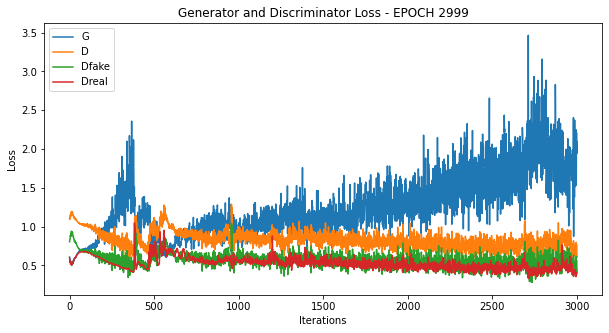

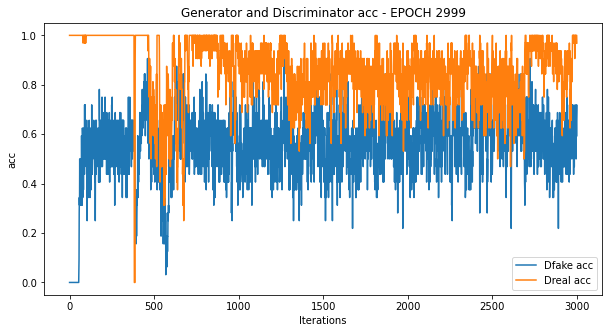

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
plt.plot(g_loss_,label="G")
plt.plot(d_loss_,label="D")
plt.plot(d_loss_fake_,label="Dfake")
plt.plot(d_loss_real_,label="Dreal")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
ymax = plt.ylim()[1]
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator acc - EPOCH {}".format(epoch))
plt.plot(d_acc_fake_,label="Dfake acc")
plt.plot(d_acc_real_,label="Dreal acc")
plt.xlabel("Iterations")
plt.ylabel("acc")
plt.legend()
ymax = plt.ylim()[1]
plt.show()

In [8]:
# Generate 1,000 samples from your fully-trained generative model. 
# Feed the generated samples to the black-box model and provide statistics on the score distributions

In [9]:
batch_size = 1000
noise_batch      = np.random.normal(0, 1, (batch_size, noise_dim))    
c_batch      = np.random.uniform(0, 1, (batch_size, conf_dim))
c_batch = c_batch[:,0]
generated_features = gen.predict([noise_batch,c_batch]) # (32, 8)
y_label = BB_clf.predict_proba(generated_features)[:,0]

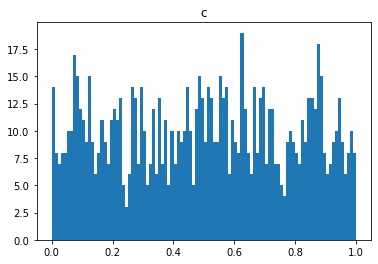

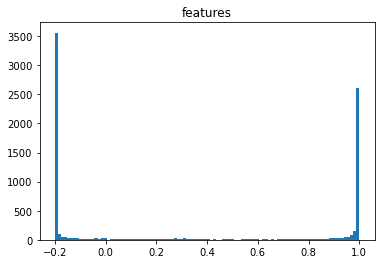

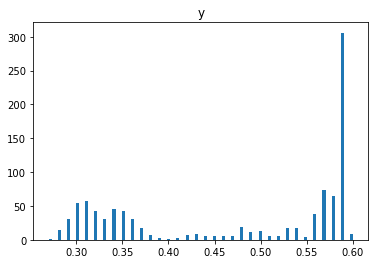

In [10]:
plt.hist(c_batch.flatten(), 100)
plt.title('c')
plt.show()
plt.hist(generated_features.flatten(), 100)
plt.title('features')
plt.show()
plt.hist(y_label.flatten(), 100)
plt.title('y')
plt.show()



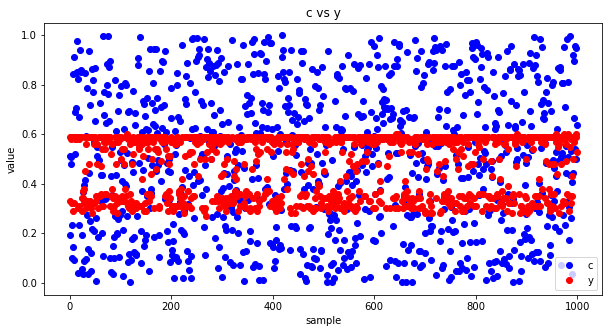

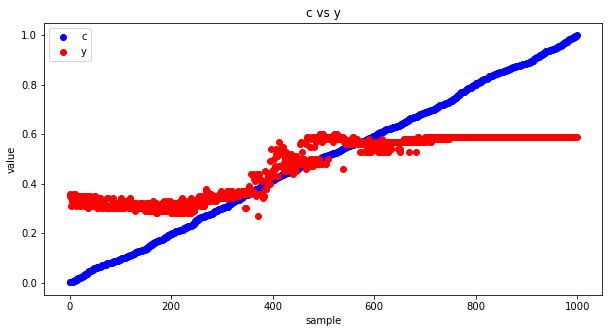

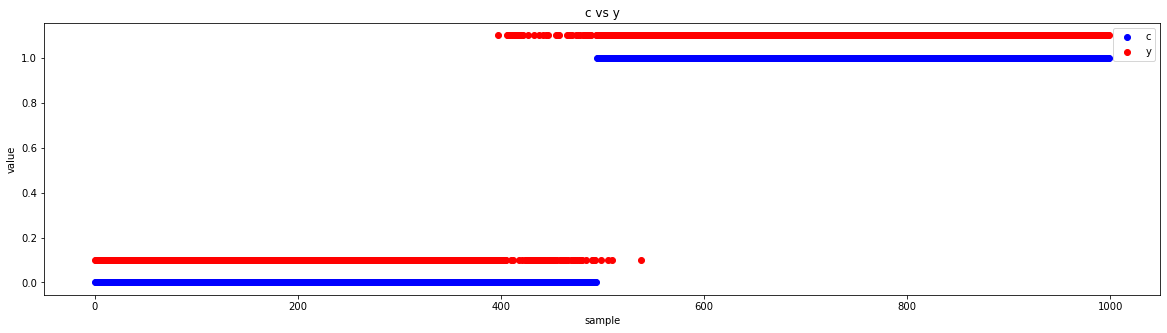

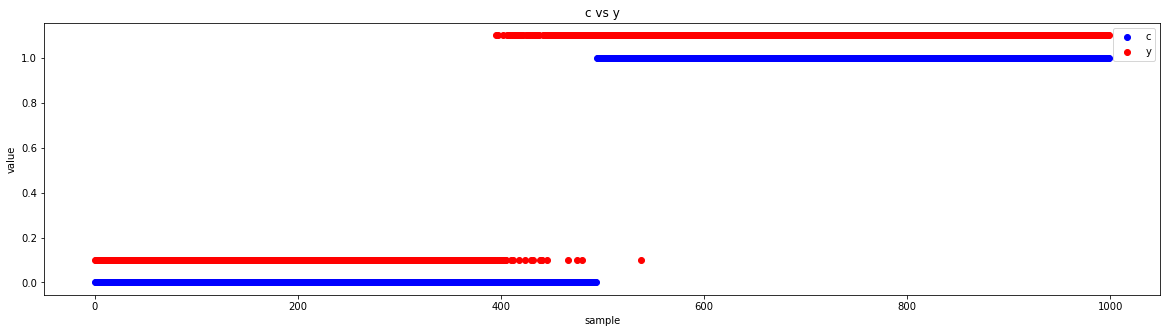

In [11]:
plt.figure(figsize=(10,5))
plt.title('c vs y')
plt.plot(c_batch.flatten(),'bo', label="c")
plt.plot(y_label.flatten(),'ro', label="y")
plt.xlabel("sample")
plt.ylabel("value")
plt.legend()
ymax = plt.ylim()[1]
plt.show()


c_sorted_idx = np.argsort(c_batch, axis=0)
sorted_c = c_batch[c_sorted_idx]
sorted_y = y_label[c_sorted_idx]
plt.figure(figsize=(10,5))
plt.title('c vs y')
plt.plot(sorted_c.flatten(),'bo', label="c")
plt.plot(sorted_y.flatten(),'ro', label="y")
plt.xlabel("sample")
plt.ylabel("value")
plt.legend()
ymax = plt.ylim()[1]
plt.show()

plt.figure(figsize=(20,5))
plt.title('c vs y')
plt.plot(np.round(sorted_c.flatten()),'bo', label="c")
plt.plot(np.round(sorted_y.flatten())+0.1,'ro', label="y")
plt.xlabel("sample")
plt.ylabel("value")
plt.legend()
ymax = plt.ylim()[1]
plt.show()

sorted_y_ = np.copy(sorted_y)
y_mean = np.mean(sorted_y)
sorted_y_[sorted_y>y_mean] = 1
sorted_y_[sorted_y<y_mean] = 0
plt.figure(figsize=(20,5))
plt.title('c vs y')
plt.plot(np.round(sorted_c.flatten()),'bo', label="c")
plt.plot(np.round(sorted_y_.flatten())+0.1,'ro', label="y")
plt.xlabel("sample")
plt.ylabel("value")
plt.legend()
ymax = plt.ylim()[1]
plt.show()

In [12]:
# accuracy
from sklearn import metrics
c_batch_round = np.round(c_batch)
y_label_round = np.round(y_label)
print("Accuracy:",metrics.accuracy_score(c_batch_round, y_label_round))

Accuracy: 0.958


In [13]:
c_1 = len(c_batch_round[c_batch_round==1])
c_0 = len(c_batch_round[c_batch_round==0])
y_1 = len(y_label_round[c_batch_round==1][y_label_round[c_batch_round==1]==1])
y_0 = len(y_label_round[c_batch_round==0][y_label_round[c_batch_round==0]==0])
print('class 1 acc ' , y_1/c_1)
print('class 0 acc ' , y_0/c_0)

class 1 acc  0.9920948616600791
class 0 acc  0.9230769230769231


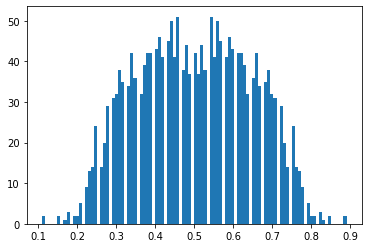

In [14]:
# draw random vectors to check BB dist
rand_features  = np.random.uniform(0, 1, (batch_size, 8))
y_label_rand = BB_clf.predict_proba(rand_features)
plt.hist(y_label_rand.flatten(), 100)
plt.show()

In [15]:
# Are there any conclusions you can draw?
# Were you more successful for a specific class of samples than another? 
# Were you more successful for a specific range of confidence scores?
# Did your model suffer from mode collapse or other problems that may have prevented it from generating more effective samples?
# If so, in what cases? Elaborate

# 
# 1. RF clf acc=0.75
# 2. 